In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import os
import sys
from tqdm import tqdm, trange

from IPython.display import Image, display

import imageio
import cairosvg
import tempfile
import os
from IPython.display import Image, display

sys.path.append("../../")
import biked_commons
from biked_commons.rendering import animation

from biked_commons.data_loading import data_loading
from biked_commons.conditioning import conditioning
from biked_commons.design_evaluation import design_evaluation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Using java as the Java binary


c:\Users\Lyler\mambaforge\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = data_loading.load_bike_bench_train()
data_variance = torch.tensor(data.var().values, device=device, dtype=torch.float32)

In [3]:
evaluators = [design_evaluation.ErgonomicsEvaluator(device=device)]
evaluator, requirement_names, requirement_types = design_evaluation.construct_tensor_evaluator(evaluators, data.columns)
rider_condition = conditioning.sample_riders(1, split="test")
use_case_condition = conditioning.sample_use_case(1, split="test")
condition = {"Rider": rider_condition, "Use Case": use_case_condition}

In [11]:
data_gd = torch.tensor(data.iloc[1:2].values, dtype=torch.float32, device=device, requires_grad=True)

all_steps = [data_gd.detach().clone()]
all_losses = []
for i in tqdm(range(1500)):
    loss = evaluator(data_gd, condition).sum()
    all_losses.append(loss.item())
    loss.backward()
    
    with torch.no_grad():
        #exit if data_gd is not changing
        if data_gd.grad is None or torch.all(data_gd.grad.abs() < 1e-6):
            print("Gradient is zero, stopping optimization.")
            break
        data_gd -= 0.001 * data_gd.grad * data_variance #equivalent to gd on the normalized data
        # data_gd = torch.clamp(data_gd, min_values, max_values)
        

    data_gd.requires_grad_()
    data_gd.grad = None

    all_steps.append(data_gd.detach().clone())

all_steps_tensor = torch.stack(all_steps, dim=0).cpu()  # shape: (steps, 1, features)
steps_df = pd.DataFrame(all_steps_tensor.squeeze(1).numpy(), columns=data.columns)

 77%|███████▋  | 1157/1500 [00:28<00:08, 39.97it/s]

Gradient is zero, stopping optimization.


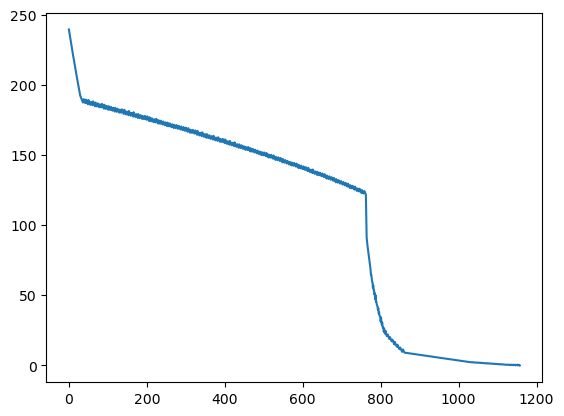

In [13]:
#plot all losses
import matplotlib.pyplot as plt
plt.plot(all_losses)


In [14]:
steps_subset = steps_df.iloc[::20, :].reset_index(drop=True)
mp4 = animation.render_to_animation(steps_subset, fps=10, mp4_filename="ergonomics.mp4", rider_dims = rider_condition[0])



Rendering frames: 100%|██████████| 58/58 [05:12<00:00,  5.39s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1068, 674) to (1072, 688) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [ ]:
from IPython.display import Video
mp4.seek(0)
display(Video(data=mp4.read(), embed=True))